Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the </br>
difficulties that sample-average methods have for nonstationary problems. Use a modified </br>
version of the 10-armed testbed in which all the q⇤(a) start out equal and then take</br>
independent random walks (say by adding a normally distributed increment with mean </br>
zero and standard deviation 0.01 to all the q⇤(a) on each step). Prepare plots like</br>
Figure 2.2 for an action-value method using sample averages, incrementally computed,</br>
and another action-value method using a constant step-size parameter, a = 0.1. Use </br>
eps = 0.1 and longer runs, say of 10,000 steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
narms = 10
nruns = 2_000
eps = 0.01
alpha = 0.1

# gaussian distribution
base_mean = 0
base_variance = 1
timestamps = 10_000


In [ ]:
def assign_mean_rewards(mean, variance):
    rewards = []
    # assign mean rewards to arms
    for n in range(narms):
        rewards.append(np.random.normal(mean, variance))
    return rewards


def get_reward(true_rewards, action, variance):
    reward_mean = true_rewards[action]
    return np.random.normal(reward_mean, variance)


def epsilon_greedy(qtable, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, narms)
    else:
        return np.argmax(qtable)
    

def update_estimate_average(qtable, reward, action, timestamp):
    current_estimate = qtable[action]
    updated_estimate = current_estimate + (reward - current_estimate) * 1/(timestamp+1)
    qtable[action] = updated_estimate
    return None


def plot_run_results(rewards):
    plt.figure(figsize=(12, 7))
    plt.plot(
        np.arange(len(rewards)), rewards
    )
    plt.title("Rewards over time")

    plt.show()

In [ ]:
total_rewards = []
total_choices = []


for n in range(nruns):
    rewards_table = assign_mean_rewards(base_mean, base_variance)
    # agent's estimate
    qtable = [0 for _ in range(narms)]
    bandit_rewards = []
    optimal_action = []

    for i in range(timestamps):
        chosen_action = epsilon_greedy(qtable, eps)
        reward = get_reward(rewards_table, chosen_action, base_variance)
        update_estimate_average(qtable, reward, chosen_action, i)

        optimal_action.append(
            int(chosen_action == np.argmax(rewards_table))
        )
        bandit_rewards.append(reward)
    
    total_rewards.append(bandit_rewards)
    total_choices.append(optimal_action)

In [5]:
mean_rewards = np.mean(total_rewards, axis=0)

In [28]:
sum_optimal_choices = np.mean(total_choices, axis=0) * 100.0

In [29]:
sum_optimal_choices

array([ 9.8 , 13.75, 16.95, ..., 35.9 , 35.75, 35.85])

In [11]:
sum_optimal_choices / (len(total_choices) * len(total_choices[0]))

np.float64(0.3560161)

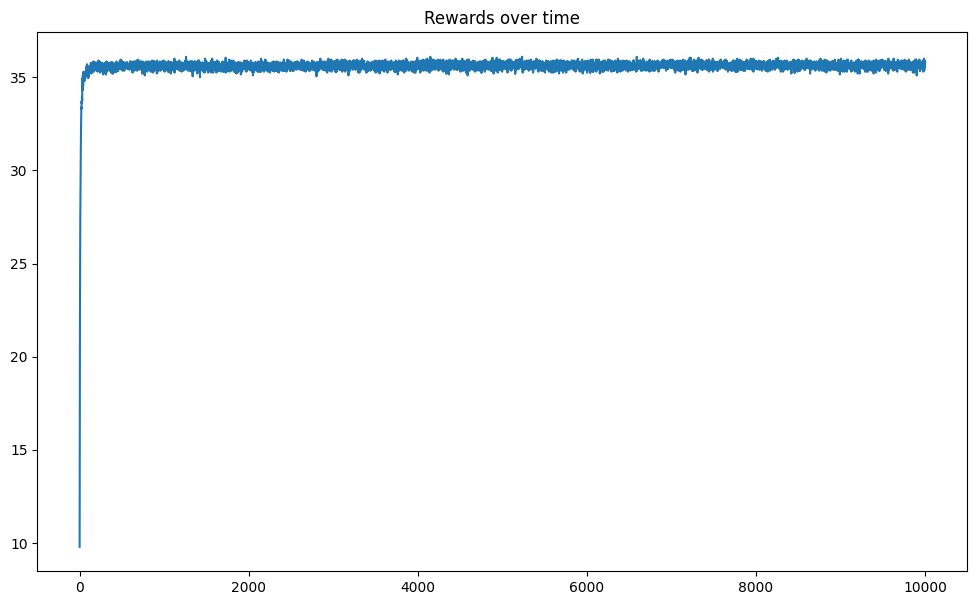

In [30]:
plot_run_results(sum_optimal_choices)

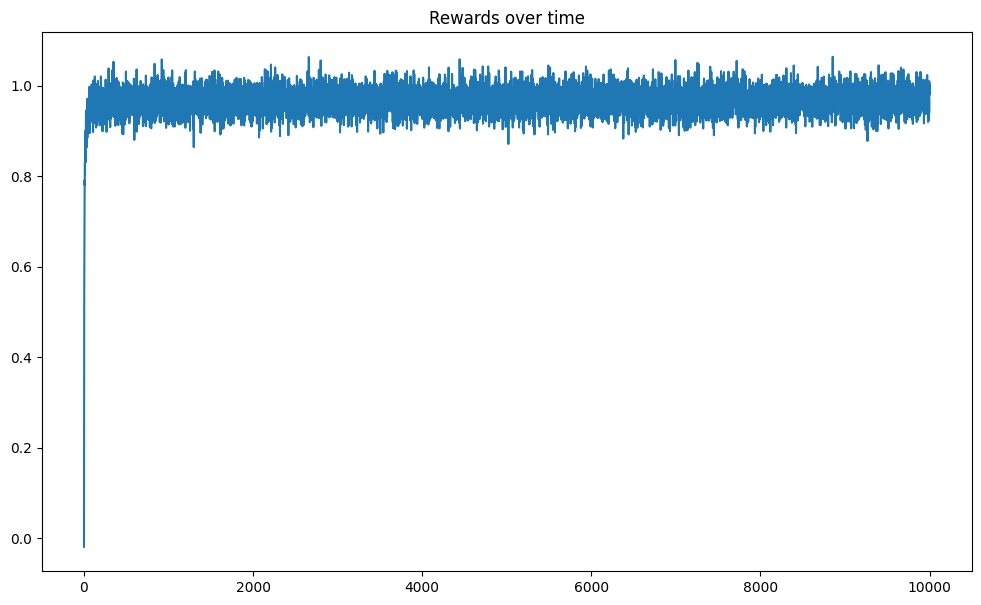

Epsilon 0.1